In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
experiment_name = 'CDR'

In [2]:
# %run init.py

print "Setting up variables & DB connection for experiment:\n"
print "*******************\n%s\n*******************"%experiment_name

# point to appropriate DBs, pickle files etc.
pkl_paths = 'pickles/%s/'%experiment_name
path_candidate_dict_pkl = pkl_paths+ 'candidate_dict.pickle' # TODO rename that
path_pubmed_ids_pkl = pkl_paths + 'pubmed_ids.pickle'
path_base_learners = pkl_paths + 'base_learner_predictions' # TODO create dirs


# Shortcuts to connect to database, initialize candidate subclass and return snorkel session
import os
#TODO: set experiment_name and restructure dir
os.environ['SNORKELDB'] = 'postgres:///snorkel'+experiment_name

from snorkel import SnorkelSession
session = SnorkelSession()
from snorkel.models import  Document, Sentence
import matplotlib.pyplot as plt
from snorkel.annotations import save_marginals
from snorkel.models import Candidate, candidate_subclass
ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

print "\nSnorkel session connected to: ",os.environ['SNORKELDB']

Setting up variables & DB connection for experiment:

*******************
CDR
*******************


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)



Snorkel session connected to:  postgres:///snorkelCDR


In [3]:
# Rebuild text
from sklearn_bridge import recreate_text_representation, candidate_dict_to_df
import numpy as np

In [4]:
from MLutils import report_to_df, train_evaluate

In [5]:
import pickle, time, seaborn, codecs
import pandas as pd
from sklearn.metrics import f1_score, classification_report

In [6]:
with open(path_candidate_dict_pkl, 'rb') as f:
    candidate_dict = pickle.load(f)

for splt in candidate_dict.keys():
    print "Split = %i : imported %i candidates" %(splt, len(candidate_dict[splt].keys()))

Split = 0 : imported 2860 candidates
Split = 1 : imported 920 candidates
Split = 2 : imported 4680 candidates
Split = 3 : imported 5576 candidates


# Load train, dev, test datasets

In [7]:
trim_text = False
trim_window = 0
use_lemmas = True

df_train = candidate_dict_to_df(candidate_dict[0],trim_text=trim_text, window=trim_window, lemmas = use_lemmas ).sort_index()
df_val = candidate_dict_to_df(candidate_dict[1],trim_text=trim_text, window=trim_window, lemmas = use_lemmas ).sort_index()
df_test = candidate_dict_to_df(candidate_dict[2],trim_text=trim_text, window=trim_window, lemmas = use_lemmas ).sort_index()

df_unlab = candidate_dict_to_df(candidate_dict[3],trim_text=trim_text, window=trim_window, lemmas = use_lemmas ).sort_index()
df_unlab['label']=np.NaN

In [8]:
def remove_line_breaks(df):
    df['text'] = map(lambda x: x.replace('\n', ' ' ),df.text)
    return df

In [9]:
def save_dataset_and_get_ids(df, path):
    """Splits data into positive and negative examples and returns a list of all the ids seperated"""
    df = remove_line_breaks(df)
    
    if not np.isnan(df.label).any(): #means we have labels
        df_pos = df[df.label==1]
        df_neg = df[df.label==-1]

        df_pos.to_csv(path+'.pos',header=False,index= False,encoding='utf-8', columns=[ 'text'],
                   sep= ' ')
        df_neg.to_csv(path+'.neg',header=False,index= False,encoding='utf-8', columns=[ 'text'],
                   sep= ' ')
        
        #keep the order of indices after reshuffling
        ids = list(df_pos.index)
        ids = ids + list(df_neg.index)
        return ids
    else:
        
        df.to_csv(path+'.nolabels',header=False,index= False,encoding='utf-8', columns=[ 'text'],
                   sep= ' ')
        return list(df.index)
    return

In [10]:
train_ids = save_dataset_and_get_ids(df_train, path_base_learners+'/cnn/df_train')

val_ids = save_dataset_and_get_ids(df_val, path_base_learners+'/cnn/df_val')

test_ids = save_dataset_and_get_ids(df_test, path_base_learners+'/cnn/df_test')

unlab_ids = save_dataset_and_get_ids(df_unlab, path_base_learners+'/cnn/df_unlab')

# CNN-text-classification

** data_helpers.py **

In [11]:
import numpy as np
import re
import itertools
from collections import Counter

In [12]:
def clean_str(string):
    """
    Tokenization/string cleaning for datasets.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()



In [45]:
# Probably not needed, can be loaded directly as df / matrix later


def load_data_and_labels(pos_file, neg_file=None):
    """
    Loads polarity data from files, splits the data into words and generates labels.
    Returns split sentences and labels.
    """
    # Load data from files
    positive_examples = list(codecs.open(pos_file, "r", encoding='utf-8' ).readlines())
    positive_examples = [s.strip() for s in positive_examples]
    if neg_file:
        negative_examples = list(codecs.open(neg_file, "r", encoding='utf-8').readlines())
        negative_examples = [s.strip() for s in negative_examples]
        x_text = positive_examples + negative_examples
    else:
        negative_examples = None
        x_text = positive_examples
        
    # Split by words
    x_text = [clean_str(sent) for sent in x_text]
    x_text = [s.split(" ") for s in x_text]
    # Generate labels
    if neg_file is not None:
        positive_labels = [[0, 1] for _ in positive_examples]
        negative_labels = [[1, 0] for _ in negative_examples]
        y = np.concatenate([positive_labels, negative_labels], 0)
        return [x_text, y]
    else:
        return x_text

In [46]:
def pad_sentences(sentences, padding_word="<PAD/>", sequence_length = 64):
    """
    Pads all sentences to the same length. The length is defined by the longest sentence.
    Returns padded sentences.
    """
    
#     sequence_length = max(len(x) for x in sentences)    #commented this out to avoid problems with building in new training data
    padded_sentences = []
    for i in range(len(sentences)):
        sentence = sentences[i]
        num_padding = max(0,sequence_length - len(sentence))
        if num_padding>0:
            new_sentence = sentence + [padding_word] * num_padding
        else: #crop sentence
            new_sentence = sentence[:sequence_length]
        padded_sentences.append(new_sentence)
    return padded_sentences

In [47]:
def build_vocab(sentences):
    """
    Builds a vocabulary mapping from word to index based on the sentences.
    Returns vocabulary mapping and inverse vocabulary mapping.
    """
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    vocabulary_inv = list(sorted(vocabulary_inv))
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return [vocabulary, vocabulary_inv]

In [48]:
def build_input_data(sentences, labels=None, vocabulary=None):
    """
    Maps sentences and labels to vectors based on a vocabulary.
    """
    x = np.array([[vocabulary[word] for word in sentence] for sentence in sentences])
    y = np.array(labels)
    return [x, y]

In [49]:
def load_data():
    """
    Loads and preprocessed data for the dataset.
    Returns input vectors, labels, vocabulary, and inverse vocabulary.
    """
    # Load and preprocess data
    train_sentences, train_labels = load_data_and_labels(pos_file=path_base_learners+'/cnn/df_train.pos', neg_file=path_base_learners+'/cnn/df_train.neg')
    val_sentences, val_labels = load_data_and_labels(pos_file=path_base_learners+'/cnn/df_val.pos', neg_file=path_base_learners+'/cnn/df_val.neg')
    test_sentences, test_labels = load_data_and_labels(pos_file=path_base_learners+'/cnn/df_test.pos', neg_file=path_base_learners+'/cnn/df_test.neg')
    unlab_sentences = load_data_and_labels(pos_file=path_base_learners+'/cnn/df_unlab.nolabels')
    
    # sentences to build vocab
    all_sentences = train_sentences+val_sentences+test_sentences+unlab_sentences
    
    
    train_sentences_padded = pad_sentences(train_sentences)
    val_sentences_padded = pad_sentences(val_sentences)
    test_sentences_padded = pad_sentences(test_sentences)
    unlab_sentences_padded = pad_sentences(unlab_sentences)
    
    
    #probably need to create all vocab and then split to val, test etc
    vocabulary, vocabulary_inv = build_vocab(pad_sentences(all_sentences))
    
    x_train, y_train = build_input_data(train_sentences_padded, train_labels, vocabulary)    
    x_val, y_val = build_input_data(val_sentences_padded, val_labels, vocabulary)
    x_test, y_test = build_input_data(test_sentences_padded, test_labels, vocabulary)
    x_unlab, _ = build_input_data(unlab_sentences_padded, val_labels, vocabulary) #passing dummy labels here, not using them afterwards
    
    
    return [x_train, y_train, x_val, y_val, x_test, y_test, x_unlab, vocabulary, vocabulary_inv ]


** model.py **

In [50]:
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D

In [51]:

from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model

In [52]:
print('Loading data')
# x, y, vocabulary, vocabulary_inv = load_data()

# Define max sequence length / or infer from training set (creates problem in new vocab though)
sequence_length = 64 # 56

X_train, y_train, X_val, y_val, X_test, y_test, X_unlab, vocabulary, vocabulary_inv = load_data()
# sequence_length = X_train.shape[1] # 56

vocabulary_size = len(vocabulary_inv) # 18765


Loading data


** Balance training set (either with class weights or undersampling) **

In [53]:
# sample_weights = dict(pd.Series(map(lambda x: x[0],y_train)).value_counts()) # inverse class_count
# sample_weights

In [54]:
# sample_weights = {0: 3302., 1: 9685.}

In [55]:
# from MLutils import balance_candidates

# X_train_us, y_train_us = balance_candidates(X_train, list(map(lambda x: x[0],y_train)))
# y_train_us = np.array(map(lambda x: np.array([1,0] if x==0 else np.array([0,1])),y_train_us))

** train params **

In [56]:
embedding_dim = 100 # original: 256
filter_sizes = [3,4,5]
num_filters = 512
drop = 0.5

epochs = 20
batch_size = 32
sequence_length = X_train.shape[-1]

# Fix F1 metric

In [57]:
# from https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_fscore_support

class Metrics(Callback):

    def __init__(self, val_data, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        self.val_data = val_data
        
    def on_epoch_end(self, epoch, logs={}):
        
        val_predict = (np.asarray(self.model.predict(self.val_data[0]))).round()
        val_predict = map(lambda x: int(x[1]),val_predict)
        val_targ = self.val_data[1]
        val_targ = map(lambda x: x[1],val_targ)
        
#         _val_f1 = f1_score(val_targ, val_predict,)
#         _val_recall = recall_score(val_targ, val_predict)
#         _val_precision = precision_score(val_targ, val_predict)
        
        _val_precision,_val_recall,_val_f1, support = precision_recall_fscore_support(val_targ, val_predict)
        
        #due to the fact that the positive class is [0,1], we discard the first elemts (correspond to neg class)
        _val_f1 = _val_f1[1]
        _val_precision = _val_precision[1]
        _val_recall = _val_recall[1]
        
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        
#         print 'val_targ[:10]',val_targ[:10],'\n', 'val_predict[:10]',val_predict[:10],'\n'
        
#         print '_val_f1',_val_f1
#         print 'support',support
        
        
        print '\n— val_f1: %.2f — val_precision: %.2f — val_recall %.2f\n' %(_val_f1, _val_precision, _val_recall)
#         print _val_f1
#         print _val_precision
#         print _val_recall
        print ''
        return


** model building **

In [58]:
def create_model(): # required for KerasClassifier
    # this returns a tensor
    print("Creating Model...")
    inputs = Input(shape=(sequence_length,), dtype='int32')
    embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length)(inputs)
    reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

    maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])

    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=2, activation='softmax')(dropout)

    # this creates a model that includes
    model = Model(inputs=inputs, outputs=output)

    checkpoint = ModelCheckpoint('cnn/weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


metrics = Metrics((X_val,y_val))

In [59]:
from keras.callbacks import EarlyStopping

In [60]:
# Wrap as sklearn classifier for learning curves
from keras.wrappers.scikit_learn import KerasClassifier

epochs = 10

model = KerasClassifier(build_fn=create_model , batch_size=batch_size, epochs=epochs, verbose=1, ) #callbacks = [EarlyStopping(patience=0)] ) #callbacks=[metrics])#, epochs=150, batch_size=10, verbose=0)

model = KerasClassifier(create_model ,callbacks=[EarlyStopping(patience=0)],  batch_size=batch_size, epochs=epochs, verbose=1,)   #callbacks = [EarlyStopping(patience=0)] ) #callbacks=[metrics])#, epochs=150, batch_size=10, verbose=0)


In [61]:
# epochs=20

In [62]:
# Skip for now - try class weights

In [63]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()

y_train_bin = list(map(lambda x: x[1],y_train))
X_train_us, y_train_us = rus.fit_sample(X_train,y_train_bin)


y_train_us = np.array(map(lambda x: [0,1] if x==1 else [1,0],y_train_us)) #convert back to logits

len(X_train_us)

2156

In [64]:
X_train_us.shape

(2156, 64)

In [65]:
y_train

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [66]:
# # with undersampling 

# model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy', f1])
# print("Traning Model...")
# model.fit(X_train_us, y_train_us, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint], 
#          validation_data=(X_val, y_val),
#          )  # starts training


In [67]:
# use val_labels for y_val

In [68]:
from MLutils import balance_candidates

In [69]:
X_train[0]

array([2174, 3018, 4520, 2175,  390,  390,  390,  390,  390,  390,  390,
        390,  390,  390,  390,  390,  390,  390,  390,  390,  390,  390,
        390,  390,  390,  390,  390,  390,  390,  390,  390,  390,  390,
        390,  390,  390,  390,  390,  390,  390,  390,  390,  390,  390,
        390,  390,  390,  390,  390,  390,  390,  390,  390,  390,  390,
        390,  390,  390,  390,  390,  390,  390,  390,  390])

In [70]:
X_train

array([[2174, 3018, 4520, ...,  390,  390,  390],
       [5909, 2175, 2464, ...,  390,  390,  390],
       [2175,  866, 6289, ...,  390,  390,  390],
       ...,
       [2174,  676, 1275, ...,  390,  390,  390],
       [1275, 1275,  676, ...,  390,  390,  390],
       [1275, 1275,  676, ...,  390,  390,  390]])

In [71]:
X_train_us, y_train_us = balance_candidates(X_train,y_train[:,1])

In [72]:
y_train_us

array([0, 1, 0, ..., 1, 1, 0])

In [73]:
X_val, y_val

(array([[5777, 1641, 1701, ...,  390,  390,  390],
        [5777, 1641, 1701, ...,  390,  390,  390],
        [5777, 1641, 1701, ...,  390,  390,  390],
        ...,
        [4089, 5851, 2258, ...,  390,  390,  390],
        [4089, 5851, 2258, ...,  390,  390,  390],
        [4089, 5851, 2258, ...,  390,  390,  390]]), array([[0, 1],
        [0, 1],
        [0, 1],
        ...,
        [1, 0],
        [1, 0],
        [1, 0]]))

In [75]:
# print("Traning Model...")
# model.fit(X_train_us, y_train_us, batch_size=batch_size, epochs=2*epochs, verbose=1, callbacks=[], 
#          validation_data=(X_val, y_val),
#          )  # starts training


# Normal training - without learning curves

In [81]:
len(y_val)

920

In [82]:
print("Traning Model...")
model.fit(X_train_us, y_train_us, batch_size=batch_size, epochs=2*epochs, verbose=1, #callbacks=[metrics], 
         #validation_data=(X_val, y_val),
         )  # starts training


Traning Model...
Creating Model...


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 2156 arrays: [array([[4742],
       [ 984],
       [6277],
       [1005],
       [5776],
       [1275],
       [ 391],
       [2174],
       [ 392],
       [3569],
       [1275],
       [ 391],
       [1275],
    ...

In [119]:
from MLutils import get_positive_logit

** quick check if keras metric is ok **

In [120]:
#evaluation with 0s

pos_class_position = model.classes_.argmax()

y_val_gold = get_positive_logit(y_val,pos_class_position)
y_val_pred_bin = model.predict(X_val)
class_report = report_to_df(classification_report(y_val_gold, y_val_pred_bin))

print class_report

3242/3242 [==============================] - 1s 364us/step
           precision  recall  f1-score  support
Classes                                        
0               0.89    0.81      0.85     2532
1               0.49    0.65      0.56      710
avg/total       0.80    0.77      0.78     3242


# Export CNN results

In [121]:
from sklearn.metrics import classification_report
from MLutils import report_to_df

from MLutils import get_positive_logit, logits_to_bin_labels,logits_to_neg_labels, classif_report_from_dicts,logits_to_bin_labels

In [122]:
results_dict = {}

# label_*_binary -> list of -1, 1
# label_*_prob_dict -> {40197: 0.96, 40198: 0.03, ... } (close to 1 -> True/Relevant class )
# NOTE: positive_labels = [[0, 1] for _ in positive_examples]

pos_class_position = model.classes_.argmax()


# pass predictions as dict & binary list
logits = model.predict_proba(X_val)
# y_val_pred = dict(zip(val_ids, list(map(lambda x: x[1], logits)))) #set the probability for the -1 class

y_val_pred_pos_logit = dict(zip(val_ids, get_positive_logit(logits, pos_class_position)))
y_val_pred_bin = dict(zip(val_ids, logits_to_bin_labels(logits))) #only used for evaluation
y_val_pred_neg = dict(zip(val_ids, logits_to_neg_labels(logits))) #only used for evaluation


# evaluation on validation set
y_val_gold = dict(df_val.label)
y_test_gold = dict(df_test.label)


# create classification report based on validation set values
class_report = report_to_df(
    classif_report_from_dicts(y_val_gold, y_val_pred_neg)
                         )
print class_report

#print another class_report

# this is correct - because the logits are ordered by + and -
print report_to_df(
    classification_report(
        logits_to_neg_labels(y_val),
        logits_to_neg_labels(logits)
    )
    )



logits = model.predict_proba(X_test)
y_test_pred_pos_logit = dict(zip(test_ids, get_positive_logit(logits, pos_class_position)))
y_test_pred_bin = dict(zip(val_ids, logits_to_bin_labels(logits))) #only used for evaluation
y_test_pred_neg = dict(zip(val_ids, logits_to_neg_labels(logits))) #only used for evaluation

logits = model.predict_proba(X_unlab)
y_unlab_pred_pos_logit = dict(zip(unlab_ids, get_positive_logit(logits, pos_class_position)))


# To delete
# logits = model.predict(X_test)
# y_test_pred = dict(zip(test_ids, list(map(lambda x: x[1], logits)))) #set the probability for the -1 class
# y_test_pred_bin = dict(zip(test_ids, list(map(lambda x: int(x[1]>=0.5), logits)))) #only used for evaluation


# logits = model.predict(X_unlab)
# y_unlab_pred = dict(zip(unlab_ids, list(map(lambda x: x[1], logits)))) #set the probability for the -1 class
# y_unlab_pred_bin = dict(zip(unlab_ids, list(map(lambda x: int(x[1]>=0.5), logits)))) #only used for evaluation



results_dict['CNN'] = {"label_val_prob+" : y_val_pred_pos_logit,
                       "label_test_prob+" : y_test_pred_pos_logit,
                       "label_unlab_prob+" : y_unlab_pred_pos_logit,
                        "classification_report": class_report,
                        "f1+": class_report.loc['1','f1-score']
                           }


3242/3242 [==============================] - 1s 358us/step
           precision  recall  f1-score  support
Classes                                        
-1              0.89    0.81      0.85     2532
1               0.49    0.65      0.56      710
avg/total       0.80    0.77      0.78     3242
           precision  recall  f1-score  support
Classes                                        
-1              0.89    0.81      0.85     2532
1               0.49    0.65      0.56      710
avg/total       0.80    0.77      0.78     3242
14727/14727 [==============================] - 5s 353us/step


In [87]:
import pickle

In [123]:
with open(path_base_learners+'/CNN_no_trim,RuS.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

# Learning curves

In [38]:
# from sklearn.model_selection import learning_curve
# from sklearn.metrics import make_scorer,f1_score,mean_squared_error
# from scipy.sparse import vstack

In [39]:
# mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
# f1_scorer = make_scorer(f1_score, greater_is_better=True)


In [158]:

# X_train_val = vstack((X_train_us,X_val) )
# y_all = (y_train.append(y_val)).values
# X_all_split = np.array([0 for i in enumerate(X_train)] + [1 for i in enumerate(X_val)])

In [159]:
#############

In [81]:
# train_sizes, train_scores, valid_scores = learning_curve(
#     model,
#     np.concatenate((X_train_us,X_val)), 
#     np.concatenate((y_train_us,y_val)), 
#     shuffle = True,
# #     random_state = 2,
# #     verb
#     #train_sizes=range(1000, X_train.shape[0], 1000), 
#     #     groups = X_all_split,
#     #     scoring = mse_scorer
    
# )

In [89]:
# from MLutils import plot_learning_curve

In [111]:
# valid_scores

array([[ 0.        ,  0.00458295,  0.73166259],
       [ 0.3776352 ,  0.00458295,  0.76894866],
       [ 0.53040024,  0.06385579,  0.81173594],
       [ 0.53895509,  0.13229453,  0.81845966],
       [ 0.54017721,  0.16468072,  0.81356968]])

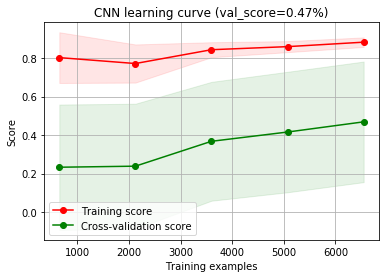

In [164]:
# # For 5 epochs
# plot_learning_curve(train_scores, 
#                         valid_scores,
#                         train_sizes=train_sizes,
#                    title = 'CNN learning curve (val_score=%.2f%%)'%valid_scores.mean(axis=1).max())

# plt.show()

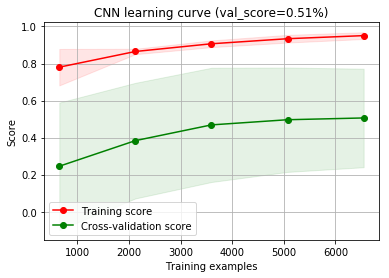

In [112]:
# # For 10 epochs
# plot_learning_curve(train_scores, 
#                         valid_scores,
#                         train_sizes=train_sizes,
#                    title = 'CNN learning curve (val_score=%.2f%%)'%valid_scores.mean(axis=1).max())

# plt.show()